# <div style="text-align: center"> Convex optimization for machine learning: Part I</div>
#### <div style="text-align: right"> Prof. Changho Suh, TA Gyeongjo Hwang, Doyeon Kim</div>

# 2. 로지스틱 회귀 (Logistic Regression)

**실습목표**
- Logistic regression의 원리를 이해하고, 이를 코드로 직접 구현한다.

**목차**
- 로지스틱 회귀 및 딥러닝의 일반적인 구조에 대해 구현
 - 매개변수 (parameter) 초기화
 - 경사 (gradient) 계산
 - 최적화 알고리즘: 경사하강법 (Gradient Descent)
- 로지스틱 회귀를 Synthetic Data 및 실제 데이터에 적용

## Logistic regression의 구조


<img src="figures/LogReg_kiank.png" style="width:650px;height:500px;" >


**Forward pass**:

학습데이터 $x^{(i)}$에 대해:
$$z^{(i)} = w^T x^{(i)} + b$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 
$$ {l}_{i}(\hat{y}^{(i)}, y^{(i)}) =  - y^{(i)}  \log(\hat{y}^{(i)}) - (1-y^{(i)} )  \log(1-\hat{y}^{(i)})$$

손실함수(loss function)는 모든 학습데이터에 대해 손실함수를 계산한 후 이들의 평균을 취하는 방식으로 구한다:
$$ J = \frac{1}{m} \sum_{i=1}^m {l}_{i}(\hat{y}^{(i)}, y^{(i)})$$

**Key steps**:
아래에서 실습으로 구현해볼 것: 
   - 모델의 파라미터 초기화
   - 모델 파라미터 학습 알고리즘
   - 학습 된 모델로 테스트 데이터로 성능측정 해보기
   - 결과분석 및 고찰

In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy

from PIL import Image
from scipy import ndimage
from RL_utils import load_dataset, generate_normal, plot, draw_boundary, Normalize

/home/isl_server1/anaconda3/envs/python2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rcParams['figure.figsize'] = (12, 8)

### 시그모이드 함수

**실습:**

시그모이드 함수를 구현하시오

__sigmoid__: $f_w(x) = \dfrac{1}{1+e^{-w^T x}}$

In [3]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: A scalar or numpy array of any size
    '''
    ### START CODE HERE ###
    result = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    return result

In [4]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


sigmoid(0) = 0.5<br/>
sigmoid(9.2) = 0.9998989708060922

### 파라미터 초기화
**실습**: 파라미터의 각 요소를 0으로 초기화하시오

In [5]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(shape=(dim, 1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [6]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


w = [[0.],[0.]] <br/>
b = 0

이미지 데이터가 인풋으로 들어가면 dim = n_px * n_px * n_channel 이 된다. (흑백이미지의 경우 n_channel: 1, 컬러이미지의 경우 n_channel: 1)

## Forward and Backward propagation

**실습:** 

$\hat{y}^{(i)}$과 $J(w)$을 계산하는 `forward()`함수와 그레디언트를 계산하는 `backward()`함수를 구현하시오

**힌트:**

Forward:
$$\hat{Y} = A = \sigma(w^T X + b) = (\hat{y}^{(1)}, \hat{y}^{(2)}, ..., \hat{y}^{(m-1)}, \hat{y}^{(m)})$$
$$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(\hat{y}^{(i)})+(1-y^{(i)})\log(1-\hat{y}^{(i)})$$


Backward:
$$ \frac{\partial J}{\partial w} = \frac{1}{m} \sum_{i=1}^m x^{(i)}(\hat{y}^{(i)}-y^{(i)}) = \frac{1}{m}X(\hat{Y}-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (\hat{y}^{(i)}-y^{(i)})$$

In [7]:
def forward(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Return:
    yhat -- prediction of corresponding input
    
    Tips:
    - Write your code step by step for the propagation
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION
    ### START CODE HERE ### (≈ 2 lines of code)
    Yhat = sigmoid(np.dot(w.T, X) + b)
    cost = (- 1 / m) * np.sum(Y * np.log(Yhat) + (1 - Y) * (np.log(1 - Yhat)))
    ### END CODE HERE ###
    
    return Yhat, cost

In [8]:
def backward(w, b, X, Y, Yhat):
    
    '''
    Return:
    grads -- gradient of parameters
    '''
    
    m = X.shape[1]
    
    # BACKWARD PROPAGATION
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1 / m) * np.dot(X, (Yhat - Y).T)
    db = (1 / m) * np.sum(Yhat - Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads

In [9]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
Yhat, cost = forward(w, b, X, Y)
grads = backward(w, b, X, Y, Yhat)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574


**Expected Output**:

<table style="width:35%">
    <tr>
        <td>  dw :</td>
        <td> [[ 0.99993216]
 [ 1.99980262]]</td>
    </tr>
    <tr>
        <td>  db  :</td>
        <td> 0.499935230625 </td>
    </tr>


</table>

### 모델 최적화

**구현:**

위에서 구현한 코드를 이용하여 모델을 학습하는 `fit()` 함수를 구현하시오

**힌트:**

$ w = w - \alpha ~ \dfrac{dJ(w)}{dw}$  
($w$ : parameter, $\alpha$ : step size or learning rate)

In [10]:
def fit(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use forward(), backward().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        Yhat, cost = forward(w, b, X, Y)
        grads = backward(w, b, X, Y, Yhat)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 200 == 0:
            print ("Cost after iteration [%i/%i]: %f" % (i, num_iterations, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [11]:
params, grads, costs = fit(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


**Expected Output**: 

<table style="width:40%">
    <tr>
       <td> w : </td>
       <td>[[ 0.1124579 ]
 [ 0.23106775]] </td>
    </tr>
    <tr>
       <td> b : </td>
       <td> 1.55930492484 </td>
    </tr>
    <tr>
       <td> dw : </td>
       <td> [[ 0.90158428]
 [ 1.76250842]] </td>
    </tr>
    <tr>
       <td> db : </td>
       <td> 0.430462071679 </td>
    </tr>

</table>

**실습 :** 

`fit()` 함수에서 학습된 파라미터 w, b를 사용하여 인풋 데이터 $x^{(i)}$가 어떤 클래스에 속하는지 예측하는 `predict()` 함수를 구현하시오

TODO:
1. $\hat{Y} = A = \sigma(w^T X + b)$ 계산

2. 1.에서 계산한 $\hat{Y}$ 값들을 기반으로 하여 어떤 클래스에 속하는지 예측 -->  $\hat{y}^{(i)}$가 0.5 이상이면 1, 이하이면 0으로 예측

In [12]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    assert(w.shape[0] == X.shape[0])
    
    ### START CODE HERE ### (≈ 4 line of code)
    Yhat = sigmoid(np.dot(w.T, X) + b)
    Yhat[Yhat > 0.5] = 1
    Yhat[Yhat <= 0.5] = 0
    Y_prediction = Yhat
    ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [13]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             predictions :
         </td>
          <td>
            [[ 1.  1.]]
         </td>  
   </tr>

</table>

## 위에서 구현한 함수들을 하나의 모델함수로 합치기

**실습:**

1. 파라미터 초기화
2. fit() 함수로 모델 학습
3. 학습된 파라미터들로 train, test 데이터에 대해 성능 측정 (accuracy)

In [14]:
def Logistic(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = fit(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

## 1- Synthetic data(Normal)에 적용

**Least square 세팅에서와 다른점:**
 1. label이 {-1, 1}가 아닌 {0, 1}이 되도록 세팅 -> Decision threshold : 0.5
 2. Least square에서는 데이터셋에서 각각의 row vector를 데이터로 봤다면 Logistic regression에서는 각각의 column vector를 데이터로 본다.

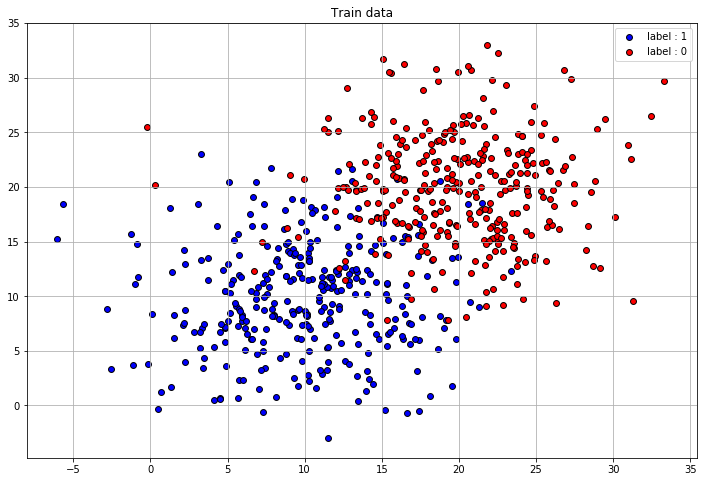

In [15]:
# 데이터 생성
(X_train, Y_train), (X_test, Y_test) = generate_normal(800, seed=2019)
plot(X_train, Y_train)

In [16]:
# 학습
d = Logistic(X_train, Y_train, X_test, Y_test, num_iterations=5000, learning_rate=0.15, print_cost=True)

Cost after iteration [0/5000]: 0.693147
Cost after iteration [200/5000]: 2.523722
Cost after iteration [400/5000]: 3.850491
Cost after iteration [600/5000]: 9.401472
Cost after iteration [800/5000]: 1.470946
Cost after iteration [1000/5000]: 1.941569
Cost after iteration [1200/5000]: 0.267933
Cost after iteration [1400/5000]: 2.019334
Cost after iteration [1600/5000]: 1.910042
Cost after iteration [1800/5000]: 1.279831
Cost after iteration [2000/5000]: 0.982930
Cost after iteration [2200/5000]: 0.320450
Cost after iteration [2400/5000]: 0.332677
Cost after iteration [2600/5000]: 0.345189
Cost after iteration [2800/5000]: 0.357362
Cost after iteration [3000/5000]: 0.368218
Cost after iteration [3200/5000]: 0.376662
Cost after iteration [3400/5000]: 0.382120
Cost after iteration [3600/5000]: 0.385017
Cost after iteration [3800/5000]: 0.386331
Cost after iteration [4000/5000]: 0.386872
Cost after iteration [4200/5000]: 0.387084
Cost after iteration [4400/5000]: 0.387167
Cost after iterati

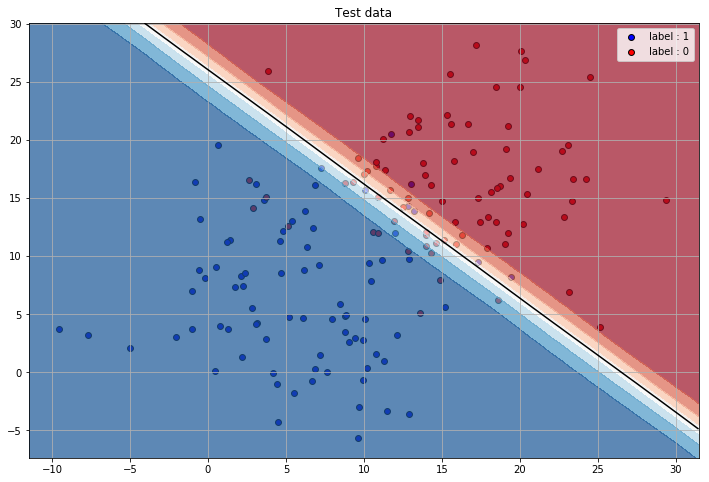

In [17]:
w = d['w']
b = d['b']
draw_boundary(w, b, X_test, Y_test, title='Test data', colormap=True)

## Least Square와 비교

In [18]:
from RL_utils import LeastSquare

Y_train[Y_train == 0] = -1
Y_test[Y_test == 0] = -1
# print train acc & test acc
w, train_acc, test_acc = LeastSquare(X_train.T, Y_train, X_test.T, Y_test, bias=True)
print('Train accuracy : {}%'.format(train_acc))
print('Test accuracy : {}%'.format(test_acc))

Train accuracy : 92.8125%
Test accuracy : 76.25%


## 2-1 실제 데이터 적용

 - MNIST는 0부터 9까지 사람의 손으로 쓴 손글씨 데이터이며 각각은 0-9로 레이블링 되어있음
 - 총 0 - 9 클래스 데이터중 {4, 9} 클래스의 손글씨 데이터만 가져와 숫자 이미지 분류문제에 적용해본다.

Shape of data: (28, 28)
Number of train data: 11791
Number of test data: 1991


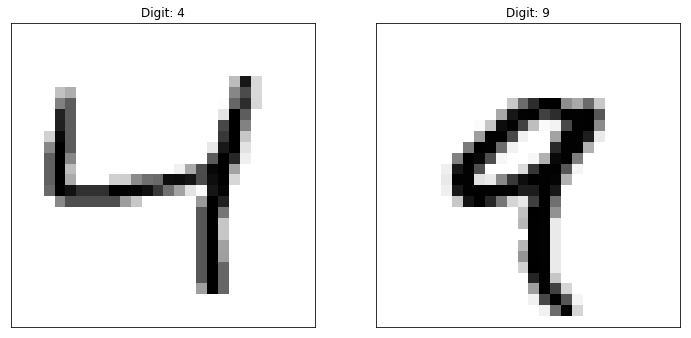

In [19]:
# 데이터셋 로드
X_train_orig = np.load('./data/X_train.npy')
X_test_orig = np.load('./data/X_test.npy')
Y_train = np.load('./data/Y_train.npy')
Y_test = np.load('./data/Y_test.npy')

# 데이터셋 기본 정보
print('Shape of data: {}'.format(X_train_orig.shape[1:]))
print('Number of train data: {}'.format(len(Y_train)))
print('Number of test data: {}'.format(len(Y_test)))

# 데이터 이미지 플로팅
plt.subplot(1, 2, 1)
plt.imshow(X_train_orig[Y_train==0][0], cmap='gray_r')
plt.title('Digit: 4')
plt.xticks([]); plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(X_train_orig[Y_train==1][0], cmap='gray_r')
plt.title('Digit: 9')
plt.xticks([]); plt.yticks([])
plt.show()

* (28, 28) 크기를 가진 이미지 데이터이기 때문에 모델에 적용하기 위해서 전처리과정이 필요하다
* 총 28 x 28 = 784개의 차원을 가지는 데이터이다

현재 학습하려고 하는 모델은 벡터형 데이터를 인풋으로 받기때문에 이미지 데이터 역시 학습을 위해서 벡터형으로 펼쳐줘야한다.

shape (n_px, npx) ---> (n_px * n_px)

**연습문제**: Training데이터셋과 test데이터셋을 벡터형으로 reshape하시오

In [20]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
### END CODE HERE ###

print('X_train_flatten shape: ' + str(X_train_flatten.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('X_test_flatten shape: ' + str(X_test_flatten.shape))
print('Y_test shape: ' + str(Y_test.shape))

X_train_flatten shape: (784, 11791)
Y_train shape: (11791,)
X_test_flatten shape: (784, 1991)
Y_test shape: (1991,)


**Standardization**

In [21]:
X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255.

In [22]:
# 학습
d = Logistic(X_train, Y_train, X_test, Y_test, num_iterations=5000, learning_rate=0.1, print_cost=True)

Cost after iteration [0/5000]: 0.693147
Cost after iteration [200/5000]: 0.158211
Cost after iteration [400/5000]: 0.131306
Cost after iteration [600/5000]: 0.119939
Cost after iteration [800/5000]: 0.113313
Cost after iteration [1000/5000]: 0.108837
Cost after iteration [1200/5000]: 0.105542
Cost after iteration [1400/5000]: 0.102975
Cost after iteration [1600/5000]: 0.100894
Cost after iteration [1800/5000]: 0.099155
Cost after iteration [2000/5000]: 0.097668
Cost after iteration [2200/5000]: 0.096374
Cost after iteration [2400/5000]: 0.095230
Cost after iteration [2600/5000]: 0.094207
Cost after iteration [2800/5000]: 0.093282
Cost after iteration [3000/5000]: 0.092439
Cost after iteration [3200/5000]: 0.091665
Cost after iteration [3400/5000]: 0.090950
Cost after iteration [3600/5000]: 0.090286
Cost after iteration [3800/5000]: 0.089666
Cost after iteration [4000/5000]: 0.089084
Cost after iteration [4200/5000]: 0.088536
Cost after iteration [4400/5000]: 0.088019
Cost after iterati

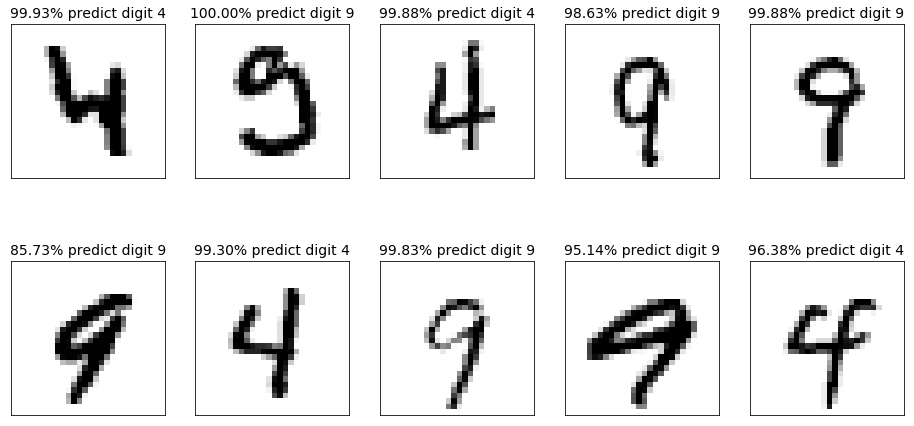

In [23]:
# 예측결과 보기
np.random.seed(2019)
idxs = np.random.choice(len(Y_test), 10, replace=False)
label_to_class = {0: '4', 1: '9'}
w = d['w']
b = d['b']

plt.figure(figsize=(16, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    pred, _ = forward(w, b, X_test[:, idx].reshape(-1, 1), Y_test)
    pred_label = d['Y_prediction_test'][0, idx]
    prob = pred if pred_label == 1 else 1 - pred
    plt.imshow(X_test_orig[idx], cmap='gray_r')
    plt.title('{:.2f}% predict digit {}'.format(prob.item() * 100, label_to_class[pred_label]), fontsize=14)
    plt.xticks([]); plt.yticks([])

## 2-2 실제 데이터 적용

**고양이와 고양이가 아닌 것의 대한 이미지 분류**: 'catnoncat.h5' 데이터셋 사용
 - 고양이는 label=1, 고양이가 아닌 것은 label=0으로 레이블링
 - 각각의 이미지는 (height, width, 3)의 shape을 가지고 있고 3의 의미는 컬러이미지(RGB 3채널)란 뜻
 - 각각의 데이터는 정사각의 이미지(height=width)

In [24]:
# (cat/non-cat) 데이터셋 로드
X_train_orig, Y_train, X_test_orig, Y_test, classes = load_dataset()

X_train_orig, X_test_orig는 모두 원본 이미지를 나타내는 array. (plt.imshow 메소드로 시각화 가능)
 - `index` 값 바꿔가면서 시각화 해보기

In [28]:
index1 = 25
index2 = 10

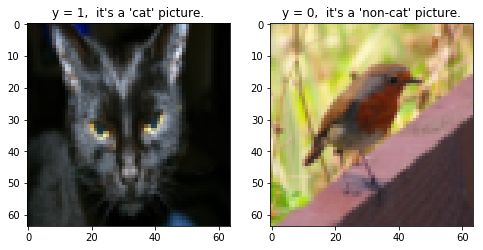

In [29]:
# Examples of a picture
plt.figure(figsize=(8, 12))
plt.subplot(2, 2, 1)
plt.imshow(X_train_orig[index1])
plt.title("y = " + str(Y_train[index1]) + ",  it's a '" + classes[Y_train[index1]].decode("utf-8") +  "' picture.")
plt.subplot(2, 2, 2)
plt.imshow(X_train_orig[index2])
plt.title("y = " + str(Y_train[index2]) + ",  it's a '" + classes[Y_train[index2]].decode("utf-8") +  "' picture.")
plt.show()

**연습문제**: 다음의 값을 찾으시오.
 - 학습 데이터의 개수 (n_train)
 - 테스트 데이터의 개수 (n_test)
 - 이미지 가로세로 픽셀개수 (n_px) (=height=width)
 
 
**Recall**: X_train_orig 는 (n_train, n_px, n_px, 3)의 shape을 가지는 numpy-array이다.

In [30]:
### START CODE HERE ### (≈ 3 lines of code)
n_train = Y_train.shape[0]
n_test = Y_test.shape[0]
n_px = X_train_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: n_train = " + str(n_train))
print ("Number of testing examples: n_test = " + str(n_test))
print ("Height/Width of each image: n_px = " + str(n_px))
print ("Each image is of size: (" + str(n_px) + ", " + str(n_px) + ", 3)")
print ("X_train_orig shape: " + str(X_train_orig.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test_orig shape: " + str(X_test_orig.shape))
print ("Y_test shape: " + str(Y_test.shape))

Number of training examples: n_train = 209
Number of testing examples: n_test = 50
Height/Width of each image: n_px = 64
Each image is of size: (64, 64, 3)
X_train_orig shape: (209, 64, 64, 3)
Y_train shape: (209,)
X_test_orig shape: (50, 64, 64, 3)
Y_test shape: (50,)


현재 학습하려고 하는 모델은 벡터형 데이터를 인풋으로 받기 때문에 이미지 데이터 역시 학습을 위해서 벡터형으로 펼쳐줘야 한다.

shape (n_px, n_px, 3) ---> (n_px \* n_px \* 3, 1)

**연습문제**: Training데이터셋과 test 데이터셋을 벡터형으로 reshape하시오

In [31]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
### END CODE HERE ###

print('X_train_flatten shape: ' + str(X_train_flatten.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('X_test_flatten shape: ' + str(X_test_flatten.shape))
print('Y_test shape: ' + str(Y_test.shape))
print('sanity check after reshaping: ' + str(X_train_flatten[0:5, 0]))

X_train_flatten shape: (12288, 209)
Y_train shape: (209,)
X_test_flatten shape: (12288, 50)
Y_test shape: (50,)
sanity check after reshaping: [17 31 56 22 33]


**Standardization**

In [32]:
X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255.

In [33]:
d = Logistic(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration [0/2000]: 0.693147
Cost after iteration [200/2000]: 0.466949
Cost after iteration [400/2000]: 0.331463
Cost after iteration [600/2000]: 0.279880
Cost after iteration [800/2000]: 0.242941
Cost after iteration [1000/2000]: 0.214820
Cost after iteration [1200/2000]: 0.192544
Cost after iteration [1400/2000]: 0.174399
Cost after iteration [1600/2000]: 0.159305
Cost after iteration [1800/2000]: 0.146542
train accuracy: 99.043062201 %
test accuracy: 70.0 %


**Expected Output**: 

<table style="width:40%"> 
    <tr>
        <td> Train Accuracy : </td> 
        <td> 99.04306220095694 % </td>
    </tr>
    <tr>
        <td>Test Accuracy : </td> 
        <td> 70.0 % </td>
    </tr>
</table> 

위 결과로 알수 있듯이 training 데이터에 대한 accuracy는 **100%**에 가까운 결과가 나오는 반면, test 데이터에 대한 결과는 **70%**정도로 매우 큰 차이를 보인다. 로지스틱 회귀 모델 자체가 Linear Classifier이기 때문에 높은 test accuracy를 내는 데에 한계가 있다.

#### iteration에 따른 loss 값 플롯

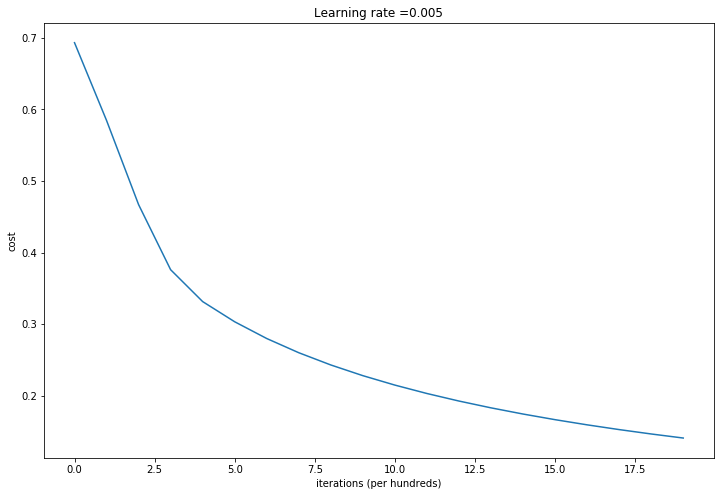

In [35]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

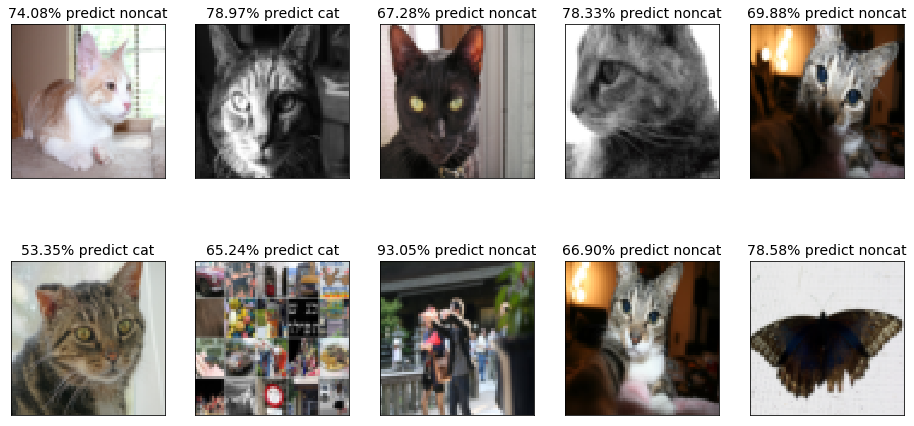

In [34]:
# 예측결과 보기
np.random.seed(2019)
idxs = np.random.choice(len(Y_test), 10, replace=False)
label_to_class = {0: 'cat', 1: 'noncat'}
w = d['w']
b = d['b']

plt.figure(figsize=(16, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    pred, _ = forward(w, b, X_test[:, idx].reshape(-1, 1), Y_test)
    pred_label = d['Y_prediction_test'][0, idx]
    prob = pred if pred_label == 1 else 1 - pred
    plt.imshow(X_test_orig[idx], cmap='gray_r')
    plt.title('{:.2f}% predict {}'.format(prob.item() * 100, label_to_class[pred_label]), fontsize=14)
    plt.xticks([]); plt.yticks([])

## Least-squares classifier와 logistic regression classifier의 공통점과 차이점에 대해 논의한다.